# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
housing = pd.read_csv('../datasets/housing_cleaned.csv')
housing_test = pd.read_csv('../datasets/test.csv')

## Check data for modeling ability

In [3]:
housing.drop(columns='Unnamed: 0', inplace=True)

In [4]:
housing.isnull().sum().sort_values(ascending=False).head()

SalePrice             879
MS SubClass             0
Roof Matl_WdShngl       0
Roof Style_Gambrel      0
Roof Style_Hip          0
dtype: int64

In [5]:
housing.head()

,MS SubClass,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,...,Garage Type_No Garage,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,60,69.22459,13517,0.905511,1.0,0.881347,0.390255,0.753001,1976,2005,...,0,0,0,0,0,0,0,0,0,1
1,60,43.00000,11492,0.905511,1.0,0.881347,0.487379,1.000000,1996,1997,...,0,0,0,0,0,0,0,0,0,1
2,20,68.00000,7922,0.696399,1.0,0.881347,0.323346,0.750170,1953,2007,...,0,0,0,0,0,0,0,0,0,1
3,60,73.00000,9802,0.696399,1.0,0.881347,0.323346,1.000000,2006,2007,...,0,0,0,0,0,0,0,0,0,1
4,50,82.00000,14235,0.905511,1.0,0.881347,0.390255,0.753001,1900,1993,...,0,0,0,0,0,0,0,0,0,1


In [6]:
housing_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


## Delete Highly Correlated Stuff
#### I decided not to do this step

In [7]:
# Create correlation matrix
corr_matrix = housing.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [8]:
to_drop

['Exterior 2nd_CmentBd',
 'Exterior 2nd_MetalSd',
 'Exterior 2nd_PreCast',
 'Exterior 2nd_VinylSd',
 'Garage Type_No Garage']

In [9]:
# Drop features 
housing.drop(housing[to_drop], axis=1, inplace=True)

## Split data back into train and test, based on y length

In [10]:
y_temp = housing.loc[housing['SalePrice'].notnull()]

In [11]:
y = y_temp['SalePrice']

### Use the log of y

In [12]:
y = np.log(y)

In [13]:
housing_train = housing.iloc[:len(y), :]
housing_test = housing.iloc[len(y):, :]

In [14]:
housing_train.drop(columns='SalePrice', inplace=True)

/var/folders/bs/c6nd19gd0g947t2sj57bskth0000gn/T/ipykernel_47911/1582098594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_train.drop(columns='SalePrice', inplace=True)


In [15]:
housing_test.drop(columns='SalePrice', inplace=True)

/var/folders/bs/c6nd19gd0g947t2sj57bskth0000gn/T/ipykernel_47911/441282992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_test.drop(columns='SalePrice', inplace=True)


In [16]:
housing_train.shape

(2049, 191)

In [17]:
housing_test.shape

(879, 191)

# Model

In [18]:
features = list(housing_train.columns)
X = housing_train[features]

In [19]:
X.shape

(2049, 191)

In [20]:
y.shape

(2049,)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [22]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

## GridSearchCV using ElasticNet

In [23]:
# These are the parameters for Elastic Net that is being passed into GridSearchCV
params = {
    'alpha': np.linspace(.0001,.01,10),
    'l1_ratio': np.linspace(.01,.99,10),
    
}

In [24]:
grids = GridSearchCV(ElasticNet(max_iter=100000), params, cv=5, verbose=1, n_jobs=-1)

In [25]:
grids.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000), n_jobs=-1,
             param_grid={'alpha': array([0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078,
       0.0089, 0.01  ]),
                         'l1_ratio': array([0.01      , 0.11888889, 0.22777778, 0.33666667, 0.44555556,
       0.55444444, 0.66333333, 0.77222222, 0.88111111, 0.99      ])},
             verbose=1)

In [26]:
grids.best_score_

0.9008601877287706

In [27]:
grids.best_params_

{'alpha': 0.0078000000000000005, 'l1_ratio': 0.33666666666666667}

In [28]:
grids.best_estimator_

ElasticNet(alpha=0.0078000000000000005, l1_ratio=0.33666666666666667,
           max_iter=100000)

In [29]:
best_grid = grids.best_estimator_
best_grid.score(X_test, y_test)

0.911801680753668

In [30]:
predictions = best_grid.predict(X_test)

In [31]:
r2_score(y_test, predictions)

0.911801680753668

In [32]:
residuals = y_test - predictions

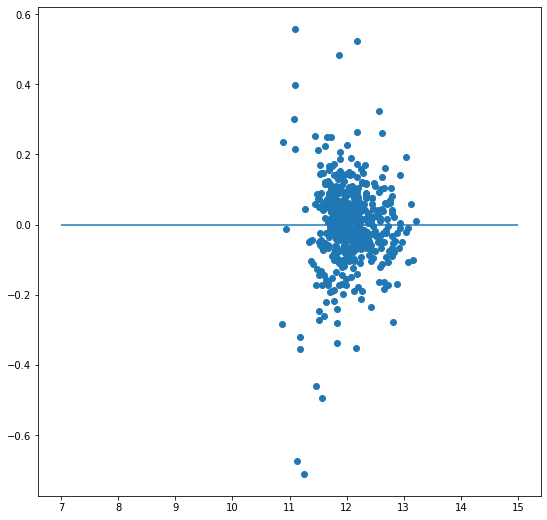

In [33]:
plt.figure(figsize=(9,9))
plt.scatter(predictions, residuals)
plt.hlines(0, 7, 15);

## Model Output

### Coefficients

**Pay Attention to me:**

Still not sure on interpreting the coefficients.  Mucho study and review of stats/math is needed.  On the to-do list.

In [34]:
coefficients = pd.DataFrame(best_grid.coef_, index=X.columns)

In [35]:
coefficients.rename(columns={0:'Coefficients'}, inplace=True)

In [36]:
coefficients.head(10)

,Coefficients
MS SubClass,-0.005914
Lot Frontage,0.011877
Lot Area,0.016812
Lot Shape,0.000000
Utilities,0.000000
Land Slope,0.000716
Overall Qual,0.081507
Overall Cond,0.005962
Year Built,0.013921
Year Remod/Add,0.044806


In [37]:
housing['TotalGoodSQ'].std()

1154.62112272196

In [38]:
np.exp(.068236)

1.0706179445014534

^^ For an added 1154 *TotalGoodSq* added, there is a 7.06% increase in *SalePrice*

## Predict using model on housing_test and submit the predictions

In [39]:
housing_test.shape

(879, 191)

In [40]:
test_transformed = ss.transform(housing_test)

In [41]:
submit_predict = best_grid.predict(test_transformed)

In [42]:
testid = pd.read_csv('../datasets/test.csv')

In [43]:
submit_predict.shape

(879,)

In [44]:
testid.shape

(879, 80)

## Export predictions

In [45]:
testid['SalePrice'] = np.exp(submit_predict)

In [46]:
submission = testid[['Id', 'SalePrice']]

In [47]:
submission.to_csv('gridsearch.csv', index=False)

In [48]:
submission.head()

,Id,SalePrice
0,2658,100756.503856
1,2718,167409.968712
2,2414,215243.230800
3,1989,110195.942357
4,625,171265.805744
